# Evaluation pipeline

**GOAL:**

Design a full pipeline for multi-dimensional evaluation of the outputs of a given combination of prompt & LLM for the AUT. 

Inputs:

- outputs of a model with originality and elaboration for the 4 objects for
    - a given LLM (GPTs, open-source models)
    - a given prompt (simple, Few shot prompting, Chain of Thought prompting, ...., RAG)

Ouput:

- graphs, radar charts (1 per object)


### TODO:

- implement a function for elaboration ++

    - elaboration 1: count number of words ✅
    - elaboration 2: count number of words and remove stop words ✅
    - elaboration 3: compute a score with PoS tagging: see with nltk. PoS = technique that involves assigning specific grammatical categories or labels (such as nouns, verbs, adjectives, adverbs, pronouns, etc.) to individual words within a sentence. Idea: a sentence with a lot of adverbs and different verbs is more elaborate that a sentence with one noun and one verb.

- implement a function for flexibility = breadth of categories you cover with your ideas

    - quite linked to similarity measure...
        - see paCy or gensim for word embeddings and similarity calculation.
    - Automated metrics to assess diversity of ideas: BLEU or ROUGE
    - more specifically with topic modelling: gensim or scikit-learn for topic modeling (e.g., LDA, NMF).
    - Compute the information entropy of word distributions within sentences.
    - Measure the lexical richness or complexity of sentences: textstats
    - sentence embeddings and compare distances: transformers

Question: Originality and elaboration are sentence-level evaluation. Is it the same for flexibility ?
    - if yes: need to compute a individual score 
    - if no: topic modeling and clusterization easier with multiple data points

<!-- HTML table for benchmark evaluation -->
<table style="border-collapse: collapse; width: 100%; border: 1px solid black;">
    <thead>
        <tr style="background-color: #f2f2f2;">
            <th style="padding: 8px; border: 1px solid black; text-align: left;">LLM</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Prompt</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Mean Originality</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Std Originality</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Elaboration</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Flexibility</th>
        </tr>
    </thead>
    <tbody>
        <!-- Row 1 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-3.5</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 2 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-3.5</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 3 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-4</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 4 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-4</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 5 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">Mistral</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi

from utils_benchmark import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [2]:
# Humans
#humans = pd.read_csv('./../data/humans_top4_objects.csv')
humans = pd.read_csv('./data_ocsai/data_for_server/humans_sim.csv')

# GPT-3.5
#gpt_35_100 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_35_100.csv')
gpt_35_100 = pd.read_csv('./data_ocsai/data_for_server/gpt_35_sim.csv')

# GPT-4
#gpt_4_100 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_4_100.csv')
gpt_4_100 = pd.read_csv('./data_ocsai/data_for_server/gpt_4_sim.csv')

# Mistral
#mistral = pd.read_csv('./data_ocsai/mistral/ocsai_eval_merged_mistral_30.csv')
mistral = pd.read_csv('./data_ocsai/data_for_server/mistral_sim.csv')

objects = list(humans['prompt'].value_counts().head(4).index)

# print length of each dataset
print('Humans:', len(humans))
print('GPT-3.5:', len(gpt_35_100))
print('GPT-4:', len(gpt_4_100))
print('Mistral:', len(mistral))

Humans: 10985
GPT-3.5: 323
GPT-4: 360
Mistral: 120


In [3]:
display(humans.head(1), gpt_35_100.head(1), gpt_4_100.head(1), mistral.head(1))

,prompt,response,originality,elaboration,cosine_dist
0,rope,use it to tie up a bicycle,1.9,7,0.242224


,prompt,response,originality,elaboration,cosine_dist
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0,0.18742


,prompt,response,originality,elaboration,cosine_dist
0,box,Transform it into a mini garden for succulents.,3.0,8.0,0.239786


,prompt,response,originality,elaboration,cosine_dist
0,brick,Use it as a doorstop,1.0,5,0.217539


## Compute Elaboration

In [4]:
data = {"humans": humans, "gpt_35": gpt_35_100, "gpt_4": gpt_4_100, "mistral": mistral}

for name, df in data.items():
    df = elaboration_SW(df)

display(humans.head(1), gpt_35_100.head(1), gpt_4_100.head(1), mistral.head(1))

,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,rope,use it to tie up a bicycle,1.9,7,0.242224,3


,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0,0.18742,7


,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,box,Transform it into a mini garden for succulents.,3.0,8.0,0.239786,5


,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,brick,Use it as a doorstop,1.0,5,0.217539,2


## Compute Flexibility

In [ ]:
# to add here (as been done before on server)

## Visualization

- histplots
- kdeplots
- Radar charts: see code from this [website](https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html)

In [7]:
humans_mean_values = humans[["originality", "elaboration", "elaboration_SW", "cosine_dist"]].mean().values
print(humans_mean_values)
print(humans[humans['prompt'] == 'box'][["originality", "elaboration", "elaboration_SW", "cosine_dist"]].mean().values)
humans.head()

[1.9013564  4.69904415 2.91770596 0.27351225]
[1.90295967 4.34628191 2.64520903 0.27585297]


,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,rope,use it to tie up a bicycle,1.9,7,0.242224,3
1,rope,steps,1.3,1,0.277950,1
2,rope,dog toy,1.4,2,0.258854,2
3,box,use it to reach something,1.7,5,0.259791,3
4,brick,strength tester (punching),2.7,3,0.293566,5


In [7]:
# normalize the columns originality, elaboration and elaboration_SW
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name in ["originality", "elaboration", "elaboration_SW", "cosine_dist"]:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

for name, df in data.items():
    data[name] = normalize(df)
    display(data[name].head(1))

,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,rope,use it to tie up a bicycle,0.225,0.122449,0.113879,0.130435


,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,box,Use it as a makeshift stool for reaching high ...,0.28,0.4,0.258219,0.428571


,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,box,Transform it into a mini garden for succulents.,0.869565,0.384615,0.72198,0.25


,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,brick,Use it as a doorstop,0.0,0.230769,0.234911,0.0


In [9]:
humans_norm = data['humans']
gpt_35_100_norm = data['gpt_35']
gpt_4_100_norm = data['gpt_4']
mistral_norm = data['mistral']

## check for each dataframe and each column
#for name, df in data.items():
#    print(name)
#    for col in ['originality', 'elaboration', 'elaboration_SW', 'cosine_dist']:
#        print(df[col].min(), df[col].max())

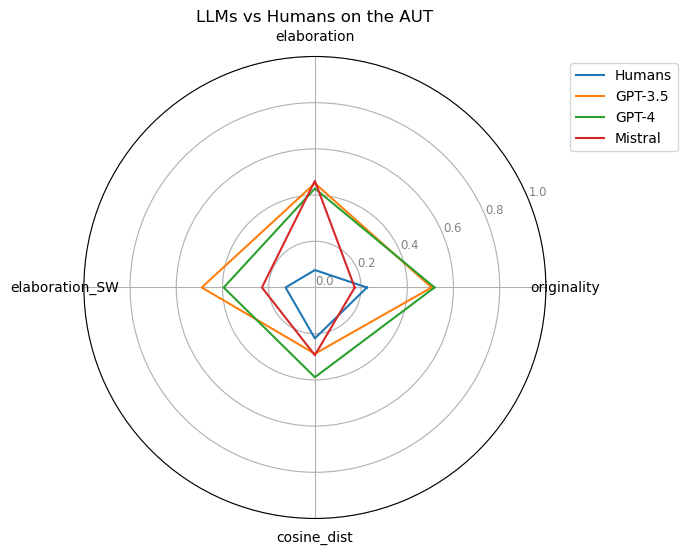

In [21]:
features = ['originality', 'elaboration', 'elaboration_SW', 'cosine_dist']

df1 = humans_norm[[col for col in features]] #pd.DataFrame(data1)
df2 = gpt_35_100_norm[[col for col in features]] #pd.DataFrame(data2)
df3 = gpt_4_100_norm[[col for col in features]] #pd.DataFrame(data3)
df4 = mistral_norm[[col for col in features]]

# List of dataframes and corresponding titles
dataframes = [df1, df2, df3, df4]
titles = ['Humans', 'GPT-3.5', 'GPT-4', 'Mistral']

# Plot radar chart for multiple dataframes
plot_radar_chart(dataframes, titles)

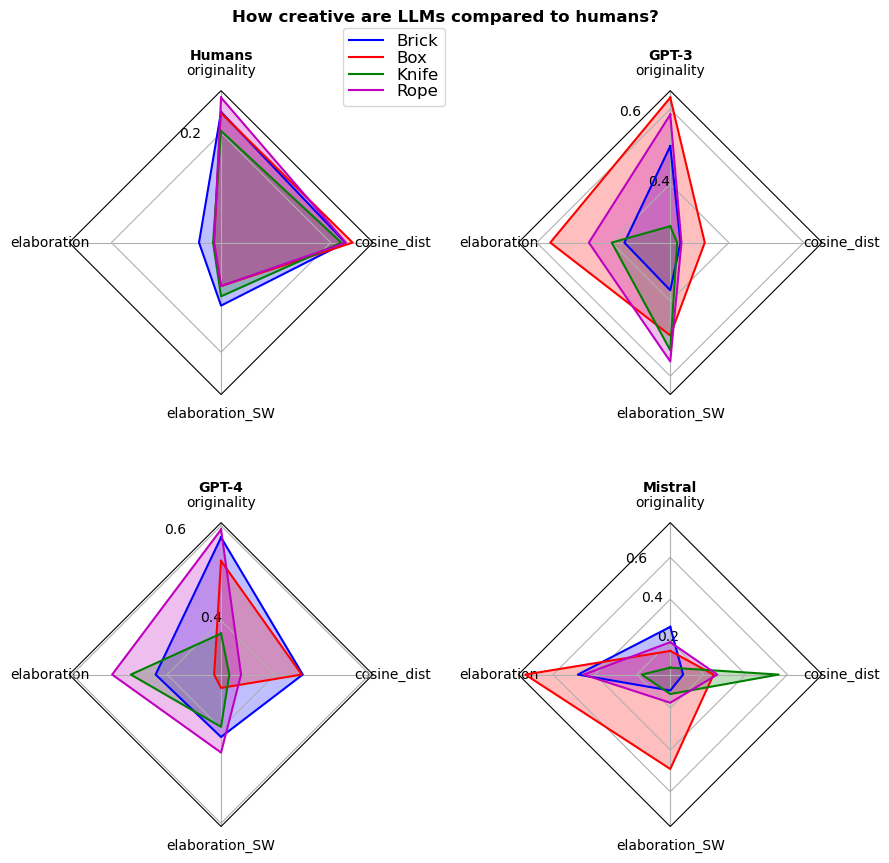

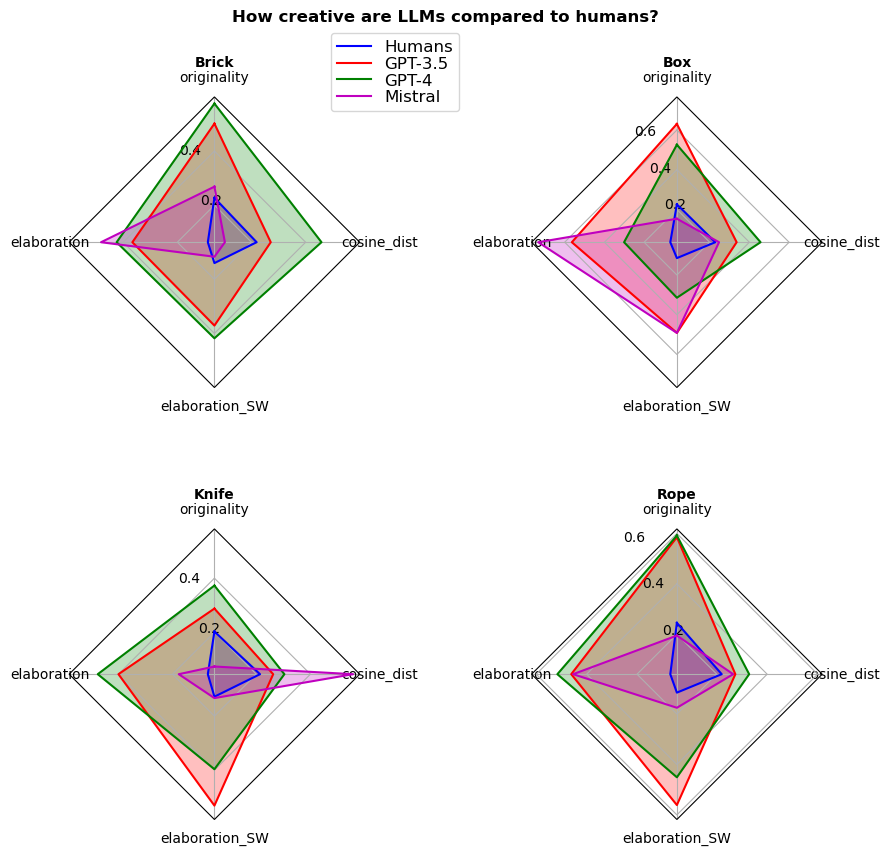

In [23]:
# dimensions to plot
features = ["originality", "elaboration", "elaboration_SW", "cosine_dist"]
#features = ["originality", "elaboration", "elaboration_SW"]

radar_charts_per_model(humans_norm, gpt_35_100_norm, gpt_4_100_norm, mistral_norm, features)
radar_charts_per_object(humans_norm, gpt_35_100_norm, gpt_4_100_norm, mistral_norm, features)

#